In [47]:
from nltk.corpus import treebank
import nltk
from nltk import pos_tag, word_tokenize
from nltk.tag import CRFTagger, DefaultTagger
from nltk.tag.brill import BrillTagger
import re
import unicodedata
from nltk.tbl.template import Template
from nltk.tag.brill import Pos, Word
from nltk.tag import untag, RegexpTagger, BrillTaggerTrainer

from matplotlib import pyplot as plt
from nltk.tag.api import TaggerI

### Data

In [2]:
train_sentences = treebank.tagged_sents()[:3000]
test_sentences = treebank.tagged_sents()[3000:]

In [59]:
len(treebank.tagged_sents())

3914

### Basic model

In [3]:
model_file = 'model.crf.tagger'
ct = CRFTagger()
ct.train(train_sentences, model_file)

In [4]:
ct = CRFTagger()
ct.set_model_file(model_file)
ct.evaluate(test_sentences)

0.9474638463198791

In [5]:
ct.tag_sents(test_sentences[20])

[[('Among', 'IN'), ('IN', 'NNP')],
 [('other', 'JJ'), ('JJ', 'NNP')],
 [('winners', 'NNS'), ('NNS', 'NNP')],
 [('Wednesday', 'NNP'), ('NNP', 'NNP')],
 [('was', 'VBD'), ('VBD', 'NNP')],
 [('*T*-2', '-NONE-'), ('-NONE-', ':')],
 [('Nippon', 'NNP'), ('NNP', 'NNP')],
 [('Shokubai', 'NNP'), ('NNP', 'NNP')],
 [(',', ','), (',', ',')],
 [('which', 'WDT'), ('WDT', 'NNP')],
 [('*T*-1', '-NONE-'), ('-NONE-', ':')],
 [('was', 'VBD'), ('VBD', 'NNP')],
 [('up', 'IN'), ('IN', 'NNP')],
 [('80', 'CD'), ('CD', 'NNP')],
 [('at', 'IN'), ('IN', 'NNP')],
 [('2,410', 'CD'), ('CD', 'NNP')],
 [('.', '.'), ('.', '.')]]

### Contextualized feature function

In [60]:
model_file = 'model2.crf.tagger'

In [7]:
pattern = re.compile(r"\d")

In [16]:
def get_basic_feature(token, preffix=''):
    feature_list = []
    
    if not token:
        return feature_list

    # Capitalization
    if token[0].isupper():
        feature_list.append(f"{preffix}_CAPITALIZATION")

    # Number
    if re.search(pattern, token) is not None:
        feature_list.append(f"{preffix}_HAS_NUM")

    # Punctuation
    punc_cat = {"Pc", "Pd", "Ps", "Pe", "Pi", "Pf", "Po"}
    if all(unicodedata.category(x) in punc_cat for x in token):
        feature_list.append(f"{preffix}_PUNCTUATION")

    # Suffix up to length 3
    if len(token) > 1:
        feature_list.append(f"{preffix}_SUF_" + token[-1:])
    if len(token) > 2:
        feature_list.append(f"{preffix}_SUF_" + token[-2:])
    if len(token) > 3:
        feature_list.append(f"{preffix}_SUF_" + token[-3:])

    feature_list.append(f"{preffix}_WORD_" + token)
    return feature_list

def get_context_feature(token, preffix=''):
    feature_list = []
    
    if not token:
        return feature_list

    # Number
    if re.search(pattern, token) is not None:
        feature_list.append(f"{preffix}_HAS_NUM")

    # Punctuation
    punc_cat = {"Pc", "Pd", "Ps", "Pe", "Pi", "Pf", "Po"}
    if all(unicodedata.category(x) in punc_cat for x in token):
        feature_list.append(f"{preffix}_PUNCTUATION")

    feature_list.append(f"{preffix}_WORD_" + token)
    return feature_list

In [65]:
def feature_func(tokens, idx):
    token = tokens[idx]
    
    token_prev = None
    token_next = None
    
    try:
        token_prev = tokens[idx-1]
    except Exception:
        pass
    
    try:
        token_next = tokens[idx+1]
    except Exception:
        pass
    
    curr_feature_list = []
    prev_feature_list = []
    next_feature_list = []
    
    if token:
        curr_feature_list = get_basic_feature(token, 'CURR')
    
    if token_prev:
        prev_feature_list = get_context_feature(token_prev, 'PREV')
    
    if token_next:
        next_feature_list = get_context_feature(token_next, 'NEXT')
        
    
    feature = curr_feature_list + prev_feature_list
    return feature

In [66]:
ct = CRFTagger(feature_func=feature_func)
ct.train(train_sentences, model_file)

In [67]:
ct = CRFTagger(feature_func=feature_func)
ct.set_model_file(model_file)
ct.evaluate(test_sentences)

0.9503561407295489

### Transformational model

In [40]:
backoff = RegexpTagger([
    (r'^-?[0-9]+(.[0-9]+)?$', 'CD'),   # cardinal numbers
    (r'(The|the|A|a|An|an)$', 'AT'),   # articles
    (r'.*able$', 'JJ'),                # adjectives
    (r'.*ness$', 'NN'),                # nouns formed from adjectives
    (r'.*ly$', 'RB'),                  # adverbs
    (r'.*s$', 'NNS'),                  # plural nouns
    (r'.*ing$', 'VBG'),                # gerunds
    (r'.*ed$', 'VBD'),                 # past tense verbs
    (r'.*', 'NN')                      # nouns (default)
])

baseline = backoff
Template._cleartemplates() #clear any templates created in earlier tests
templates = [Template(Pos([-1])), Template(Pos([-1]), Word([0]))]

In [46]:
tagger1 = baseline

eval_scores = []


for i in range(10):
    tt = BrillTaggerTrainer(tagger1, templates, trace=3)
    tagger1 = tt.train(train_sentences, max_rules=10)
    score = tagger1.evaluate(test_sentences)
    eval_scores.append(score)

TBL train (fast) (seqs: 3000; tokens: 77511; tpls: 2; min score: 2; min acc: None)
Finding initial useful rules...
    Found 9476 useful rules.

           B      |
   S   F   r   O  |        Score = Fixed - Broken
   c   i   o   t  |  R     Fixed = num tags changed incorrect -> correct
   o   x   k   h  |  u     Broken = num tags changed correct -> incorrect
   r   e   e   e  |  l     Other = num tags changed incorrect -> incorrect
   e   d   n   r  |  e
------------------+-------------------------------------------------------
38973897   0  13  | AT->DT if Pos:NN@[-1]
27042704   0   0  | NN->, if Pos:NN@[-1] & Word:,@[0]
20392039   0   0  | NN->. if Pos:NN@[-1] & Word:.@[0]
13651365   0   0  | NN->IN if Pos:NN@[-1] & Word:of@[0]
13541354   0   3  | NN->TO if Pos:NN@[-1] & Word:to@[0]
 895 920  25 154  | NN->VB if Pos:TO@[-1]
 802 803   1   6  | NN->IN if Pos:NN@[-1] & Word:in@[0]
 717 719   2   4  | NN->CC if Pos:NN@[-1] & Word:and@[0]
 714 714   0   0  | NN->, if Pos:NNS@[-1] & Word

  78  78   0   0  | NN->. if Pos:VBG@[-1] & Word:.@[0]
  74  74   0   0  | NN->MD if Pos:NN@[-1] & Word:will@[0]
  72  72   0   0  | NN->$ if Pos:NN@[-1] & Word:$@[0]
  72  72   0   0  | NN->: if Pos:NN@[-1] & Word:--@[0]
  71  71   0   0  | NN->`` if Pos:NN@[-1] & Word:``@[0]
  70 103  33  13  | VBD->VBN if Pos:RB@[-1]
  69  69   0   0  | NNS->VBZ if Pos:NN@[-1] & Word:says@[0]
  68  68   0   0  | IN->VBD if Pos:NNS@[-1] & Word:were@[0]
TBL train (fast) (seqs: 3000; tokens: 77511; tpls: 2; min score: 2; min acc: None)
Finding initial useful rules...
    Found 14276 useful rules.

           B      |
   S   F   r   O  |        Score = Fixed - Broken
   c   i   o   t  |  R     Fixed = num tags changed incorrect -> correct
   o   x   k   h  |  u     Broken = num tags changed correct -> incorrect
   r   e   e   e  |  l     Other = num tags changed incorrect -> incorrect
   e   d   n   r  |  e
------------------+-------------------------------------------------------
  67  73   6   8  | NN

In [56]:
for i in range(40):
    tt = BrillTaggerTrainer(tagger1, templates, trace=3)
    tagger1 = tt.train(train_sentences, max_rules=10)
    score = tagger1.evaluate(test_sentences)
    eval_scores.append(score)

TBL train (fast) (seqs: 3000; tokens: 77511; tpls: 2; min score: 2; min acc: None)
Finding initial useful rules...
    Found 13671 useful rules.

           B      |
   S   F   r   O  |        Score = Fixed - Broken
   c   i   o   t  |  R     Fixed = num tags changed incorrect -> correct
   o   x   k   h  |  u     Broken = num tags changed correct -> incorrect
   r   e   e   e  |  l     Other = num tags changed incorrect -> incorrect
   e   d   n   r  |  e
------------------+-------------------------------------------------------
   6   6   0   0  | NNP->NN if Pos:IN@[-1] & Word:comment@[0]
   6   6   0   0  | NNP->NN if Pos:IN@[-1] & Word:course@[0]
   6   6   0   0  | NNP->NN if Pos:IN@[-1] & Word:interest@[0]
   6   6   0   0  | NNP->NN if Pos:IN@[-1] & Word:investment@[0]
   6   6   0   0  | NNP->NN if Pos:IN@[-1] & Word:today@[0]
   6   6   0   1  | NNP->NN if Pos:IN@[-1] & Word:trade@[0]
   6   6   0   0  | NNP->NN if Pos:IN@[-1] & Word:vice@[0]
   6   6   0   0  | NNP->NN if Pos

   5   5   0   0  | NN->-NONE- if Pos:NN@[-1] & Word:*T*-3@[0]
   5   5   0   0  | NN->-NONE- if Pos:VBG@[-1] & Word:*T*-2@[0]
   5   5   0   0  | NN->CD if Pos:NN@[-1] & Word:three@[0]
   5   5   0   0  | NN->DT if Pos:NN@[-1] & Word:both@[0]
   5   5   0   0  | NN->DT if Pos:NN@[-1] & Word:those@[0]
   5   5   0   0  | NN->DT if Pos:VBG@[-1] & Word:any@[0]
   5   5   0   1  | NN->IN if Pos:NN@[-1] & Word:above@[0]
   5   5   0   0  | NN->IN if Pos:NN@[-1] & Word:among@[0]
   5   5   0   0  | NN->IN if Pos:NN@[-1] & Word:like@[0]
   5   5   0   0  | NN->JJ if Pos:DT@[-1] & Word:bad@[0]
TBL train (fast) (seqs: 3000; tokens: 77511; tpls: 2; min score: 2; min acc: None)
Finding initial useful rules...
    Found 13628 useful rules.

           B      |
   S   F   r   O  |        Score = Fixed - Broken
   c   i   o   t  |  R     Fixed = num tags changed incorrect -> correct
   o   x   k   h  |  u     Broken = num tags changed correct -> incorrect
   r   e   e   e  |  l     Other = num tags

TBL train (fast) (seqs: 3000; tokens: 77511; tpls: 2; min score: 2; min acc: None)
Finding initial useful rules...
    Found 13580 useful rules.

           B      |
   S   F   r   O  |        Score = Fixed - Broken
   c   i   o   t  |  R     Fixed = num tags changed incorrect -> correct
   o   x   k   h  |  u     Broken = num tags changed correct -> incorrect
   r   e   e   e  |  l     Other = num tags changed incorrect -> incorrect
   e   d   n   r  |  e
------------------+-------------------------------------------------------
   5   5   0   0  | NNP->NN if Pos:IN@[-1] & Word:debt@[0]
   5   5   0   0  | NNP->NN if Pos:IN@[-1] & Word:fact@[0]
   5   5   0   0  | NNP->NN if Pos:IN@[-1] & Word:health@[0]
   5   5   0   0  | NNP->NN if Pos:IN@[-1] & Word:income@[0]
   5   5   0   0  | NNP->NN if Pos:IN@[-1] & Word:instance@[0]
   5   5   0   0  | NNP->NN if Pos:IN@[-1] & Word:record@[0]
   5   5   0   0  | NNP->NN if Pos:NNP@[-1] & Word:aid@[0]
   5   5   0   0  | NNP->NN if Pos:NNP@[-

   4   4   0   0  | NNP->VB if Pos:MD@[-1]
   4   4   0   6  | NNP->VB if Pos:VBP@[-1]
   4   4   0   0  | NNP->VBP if Pos:PRP@[-1]
   4   5   1   2  | RB->JJ if Pos:PRP$@[-1]
   4   5   1   2  | VBD->VBN if Pos::@[-1]
   4   4   0   0  | VBD->VBN if Pos:VBN@[-1]
   4   5   1   0  | VBG->NN if Pos:CD@[-1]
   4   4   0   0  | VBG->VB if Pos:MD@[-1]
   4   4   0   0  | VBP->VB if Pos:MD@[-1]
   4   4   0   0  | WDT->IN if Pos:VBZ@[-1]
TBL train (fast) (seqs: 3000; tokens: 77511; tpls: 2; min score: 2; min acc: None)
Finding initial useful rules...
    Found 13480 useful rules.

           B      |
   S   F   r   O  |        Score = Fixed - Broken
   c   i   o   t  |  R     Fixed = num tags changed incorrect -> correct
   o   x   k   h  |  u     Broken = num tags changed correct -> incorrect
   r   e   e   e  |  l     Other = num tags changed incorrect -> incorrect
   e   d   n   r  |  e
------------------+-------------------------------------------------------
   4   4   0   0  | -NONE--

TBL train (fast) (seqs: 3000; tokens: 77511; tpls: 2; min score: 2; min acc: None)
Finding initial useful rules...
    Found 13432 useful rules.

           B      |
   S   F   r   O  |        Score = Fixed - Broken
   c   i   o   t  |  R     Fixed = num tags changed incorrect -> correct
   o   x   k   h  |  u     Broken = num tags changed correct -> incorrect
   r   e   e   e  |  l     Other = num tags changed incorrect -> incorrect
   e   d   n   r  |  e
------------------+-------------------------------------------------------
   4   4   0   0  | NN->JJ if Pos:CD@[-1] & Word:common@[0]
   4   4   0   0  | NN->JJ if Pos:DT@[-1] & Word:British@[0]
   4   4   0   0  | NN->JJ if Pos:DT@[-1] & Word:economic@[0]
   4   4   0   0  | NN->JJ if Pos:DT@[-1] & Word:expensive@[0]
   4   4   0   0  | NN->JJ if Pos:DT@[-1] & Word:female@[0]
   4   4   0   0  | NN->JJ if Pos:DT@[-1] & Word:general@[0]
   4   4   0   0  | NN->JJ if Pos:DT@[-1] & Word:huge@[0]
   4   4   0   0  | NN->JJ if Pos:DT@[-

   4   4   0   0  | NN->VBN if Pos:VB@[-1] & Word:paid@[0]
   4   4   0   0  | NN->WDT if Pos:IN@[-1] & Word:which@[0]
   4   4   0   1  | NN->WP if Pos:VB@[-1] & Word:what@[0]
   4   4   0   0  | NN->WRB if Pos:NN@[-1] & Word:where@[0]
   4   4   0   0  | NN->WRB if Pos:VB@[-1] & Word:why@[0]
   4   4   0   0  | NN->`` if Pos:NN@[-1] & Word:``@[0]
   4   4   0   0  | NN->`` if Pos:POS@[-1] & Word:``@[0]
   4   4   0   0  | NN->`` if Pos:VB@[-1] & Word:``@[0]
   4   4   0   0  | NNP->-LRB- if Pos:''@[-1] & Word:-LRB-@[0]
   4   4   0   0  | NNP->-NONE- if Pos:,@[-1] & Word:*-3@[0]
TBL train (fast) (seqs: 3000; tokens: 77511; tpls: 2; min score: 2; min acc: None)
Finding initial useful rules...
    Found 13381 useful rules.

           B      |
   S   F   r   O  |        Score = Fixed - Broken
   c   i   o   t  |  R     Fixed = num tags changed incorrect -> correct
   o   x   k   h  |  u     Broken = num tags changed correct -> incorrect
   r   e   e   e  |  l     Other = num tags chang

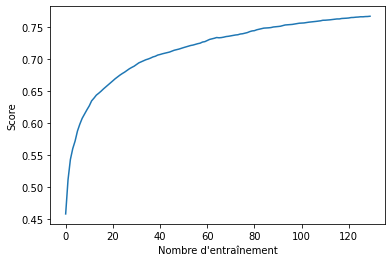

In [70]:
plt.plot(list(range(len(eval_scores))), eval_scores)
plt.xlabel("Nombre d'entraînement")
plt.ylabel('Score')
plt.show()

In [68]:
eval_scores

[0.45750053960716597,
 0.5110295704726959,
 0.5427153032592272,
 0.5597668897042952,
 0.5716814159292035,
 0.587308439456076,
 0.5980574142024606,
 0.6072523203108138,
 0.6139002805957263,
 0.6205482408806389,
 0.6267213468594863,
 0.6345780271962012,
 0.6388517159507878,
 0.643557090438161,
 0.6464925534211095,
 0.6496870278437298,
 0.6532268508525794,
 0.656378156701921,
 0.6595294625512627,
 0.6628966112669976,
 0.6660047485430607,
 0.6692423915389596,
 0.6721346859486294,
 0.6748974746384632,
 0.6773580833153464,
 0.6796028491258364,
 0.682149794949277,
 0.6848262464925534,
 0.6869415065832074,
 0.6888409238074682,
 0.6913878696309087,
 0.6940643211741852,
 0.6957047269587741,
 0.6973019641700842,
 0.6989855385279516,
 0.7001510900064752,
 0.7016188214979495,
 0.7033887330023743,
 0.7044247787610619,
 0.706281027412044,
 0.7071875674508957,
 0.7083099503561407,
 0.7091733218217138,
 0.7101661990071229,
 0.7109864018994172,
 0.7123246276710554,
 0.7138355277358084,
 0.71478523634793

In [71]:
tagger1.tag_sents(test_sentences[0])

[[('At', 'NN'), ('IN', 'NN')],
 [('Tokyo', 'NN'), ('NNP', 'NN')],
 [(',', 'NN'), (',', ',')],
 [('the', 'AT'), ('DT', 'NN')],
 [('Nikkei', 'NN'), ('NNP', 'NN')],
 [('index', 'NN'), ('NN', 'NN')],
 [('of', 'NN'), ('IN', 'NN')],
 [('225', 'CD'), ('CD', 'NN')],
 [('selected', 'VBD'), ('VBN', '-NONE-')],
 [('issues', 'NNS'), ('NNS', 'IN')],
 [(',', 'NN'), (',', ',')],
 [('which', 'NN'), ('WDT', 'NN')],
 [('*T*-1', 'NN'), ('-NONE-', 'NN')],
 [('gained', 'VBD'), ('VBD', '-NONE-')],
 [('132', 'CD'), ('CD', 'NN')],
 [('points', 'NNS'), ('NNS', 'IN')],
 [('Tuesday', 'NN'), ('NNP', 'NN')],
 [(',', 'NN'), (',', ',')],
 [('added', 'VBD'), ('VBD', '-NONE-')],
 [('14.99', 'CD'), ('CD', 'NN')],
 [('points', 'NNS'), ('NNS', 'IN')],
 [('to', 'NN'), ('TO', 'NN')],
 [('35564.43', 'CD'), ('CD', 'NN')],
 [('.', 'NN'), ('.', '.')]]

In [74]:
eval_scores[-1]

0.7671055471616663